![](https://cdn.dribbble.com/users/1044993/screenshots/14088046/media/aa04f996146242fab4ca7a9c0fe5370c.png?compress=1&resize=1000x750&vertical=top)

[Crab Age Prediction](https://www.kaggle.com/competitions/playground-series-s3e16/data)

### Context

> **The dataset is used to estimate the age of the crab based on the physical attributes. Its a great starting point for classical regression analysis and feature engineering and understand the impact of feature engineering in Data Science domain.**

### Content

> **Crab is very tasty and many countries of the world import huge amount of crabs for consumption every year. The main benefits of crab farming are, labor cost is very low, production cost is comparatively lower and they grow very fast. Commercial crab farming business is developing the lifestyle of the people of coastal areas. By proper care and management we can earn more from crab farming business than shrimp farming. You can raise mud crabs in two systems. Grow out farming and fattening systems.**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import warnings

from sklearn.model_selection import KFold, train_test_split,GridSearchCV
from sklearn.metrics import mean_absolute_error
from lightgbm import LGBMRegressor

from colorama import Style, Fore
red = Style.BRIGHT + Fore.RED
blu = Style.BRIGHT + Fore.BLUE
mgt = Style.BRIGHT + Fore.MAGENTA
gld = Style.BRIGHT + Fore.YELLOW
res = Style.RESET_ALL

warnings.filterwarnings(action = 'ignore')

In [2]:
rc = {
    "axes.facecolor": "#F6F6F6",
    "figure.facecolor": "#F6F6F6",
    "axes.edgecolor": "#000000",
    "grid.color": "#EBEBE7",
    "font.family": "serif",
    "axes.labelcolor": "#000000",
    "xtick.color": "#000000",
    "ytick.color": "#000000",
    "grid.alpha": 0.4
}

sns.set(rc=rc)

In [3]:
train = pd.read_csv('/kaggle/input/playground-series-s3e16/train.csv').drop('id',axis = 1)
test = pd.read_csv('/kaggle/input/playground-series-s3e16/test.csv').drop('id',axis = 1)
sub = pd.read_csv('/kaggle/input/playground-series-s3e16/sample_submission.csv')

In [4]:
df = train.copy()

In [5]:
def summarize(data):
    
    result = pd.DataFrame()

    result['Count'] = data.count()
    result['Nunique'] = data.nunique().values
    result['Missing value'] = data.isna().sum().values
    result['Freq Value'] = data.mode().iloc[0]
    result['Min'] = data.describe().T['min']
    result['Max'] = data.describe().T['max']
    result['Mean'] = data.describe().T['mean']
    result['Median'] = data.describe().T['50%']

    return result

In [6]:
summarize(df)

,Count,Nunique,Missing value,Freq Value,Min,Max,Mean,Median
Sex,74051,3,0,M,NaN,NaN,NaN,NaN
Length,74051,144,0,1.5625,0.187500,2.012815,1.317460,1.375000
Diameter,74051,122,0,1.125,0.137500,1.612500,1.024496,1.075000
Height,74051,65,0,0.375,0.000000,2.825000,0.348089,0.362500
Weight,74051,3096,0,32.162508,0.056699,80.101512,23.385217,23.799405
Shucked Weight,74051,1766,0,9.879801,0.028349,42.184056,10.104270,9.908150
Viscera Weight,74051,967,0,5.868347,0.042524,21.545620,5.058386,4.989512
Shell Weight,74051,1048,0,7.796112,0.042524,28.491248,6.723870,6.931453
Age,74051,28,0,9,1.000000,29.000000,9.967806,10.000000


# EDA

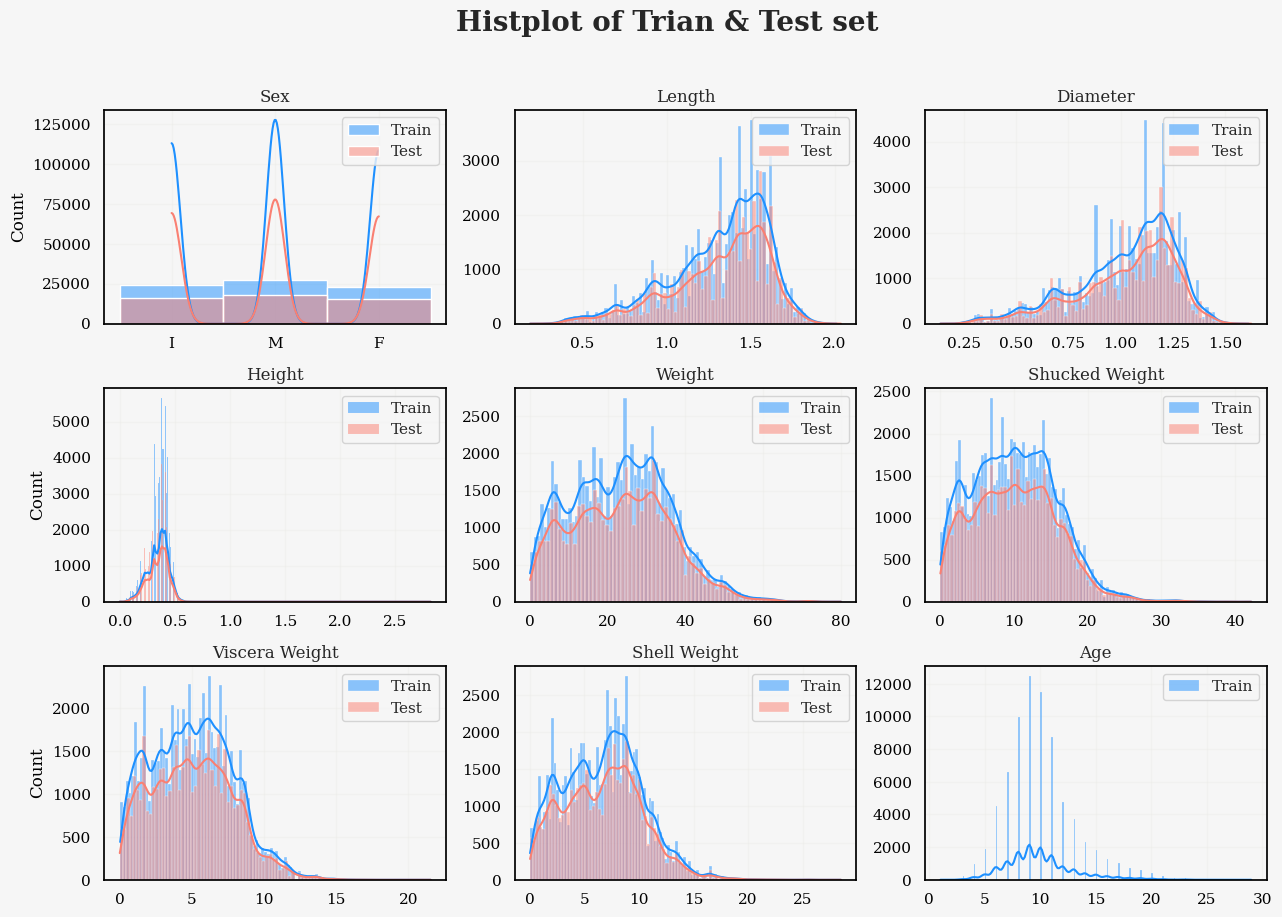

In [7]:
fig,ax = plt.subplots(ncols = 3, nrows = 3, figsize = (15,10))
ax = ax.flatten()

palette = ['dodgerblue','salmon']
labels = ['Train','Test']

fig.subplots_adjust(hspace = 0.3)

for _,graph in enumerate([df,test]):
    for i,col in enumerate(graph.columns):
        
        sns.histplot(data = graph,
                    x = col,
                    ax = ax[i],
                    alpha = 0.5,
                    color = palette[_],
                    kde = True,
                    label = labels[_])
        
        ax[i].legend(loc = 'upper right')
        
        if i % 3 != 0 :
            
            ax[i].set_ylabel('')
            
        ax[i].set_xlabel('')
        ax[i].set_title(col)
        
        
    fig.suptitle('Histplot of Trian & Test set', fontsize = 20, weight = 'bold')

>**The distribution of data between the train and test sets does not appear to be significant.**

>**Age, the target variable, is a numeric variable, but is it correct to view it as a continuous variable? I'll have to think about it.**

Text(0.5, 1.0, 'Correalation Heatmap')

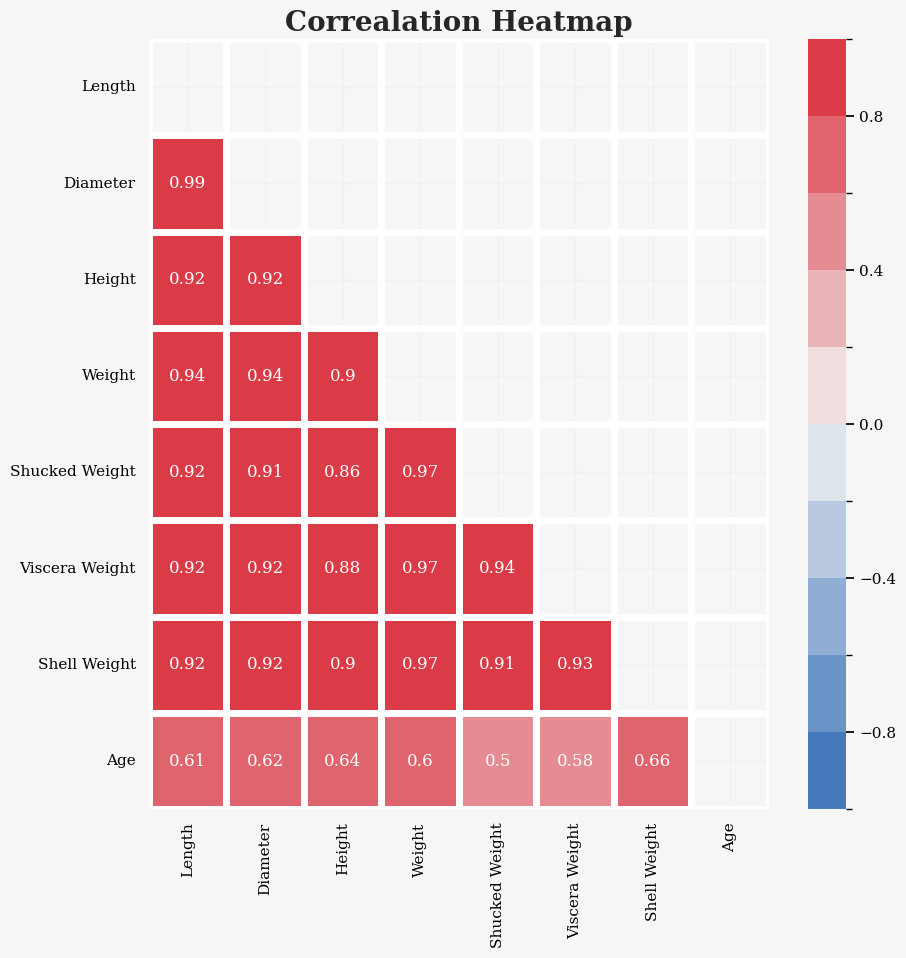

In [8]:
cmap = sns.diverging_palette(250,10, as_cmap = True)
norm = mpl.colors.BoundaryNorm(boundaries = np.arange(-1,1.2,0.2), ncolors = cmap.N)

num_cols = df.describe().columns

corr = df[num_cols].corr()
mask = np.triu(np.ones_like(corr))

plt.figure(figsize = (10,10))

sns.heatmap(corr, mask = mask, cmap = cmap, norm = norm, annot = True, linewidths = 5)

plt.title('Correalation Heatmap', fontsize = 20, weight = 'bold')

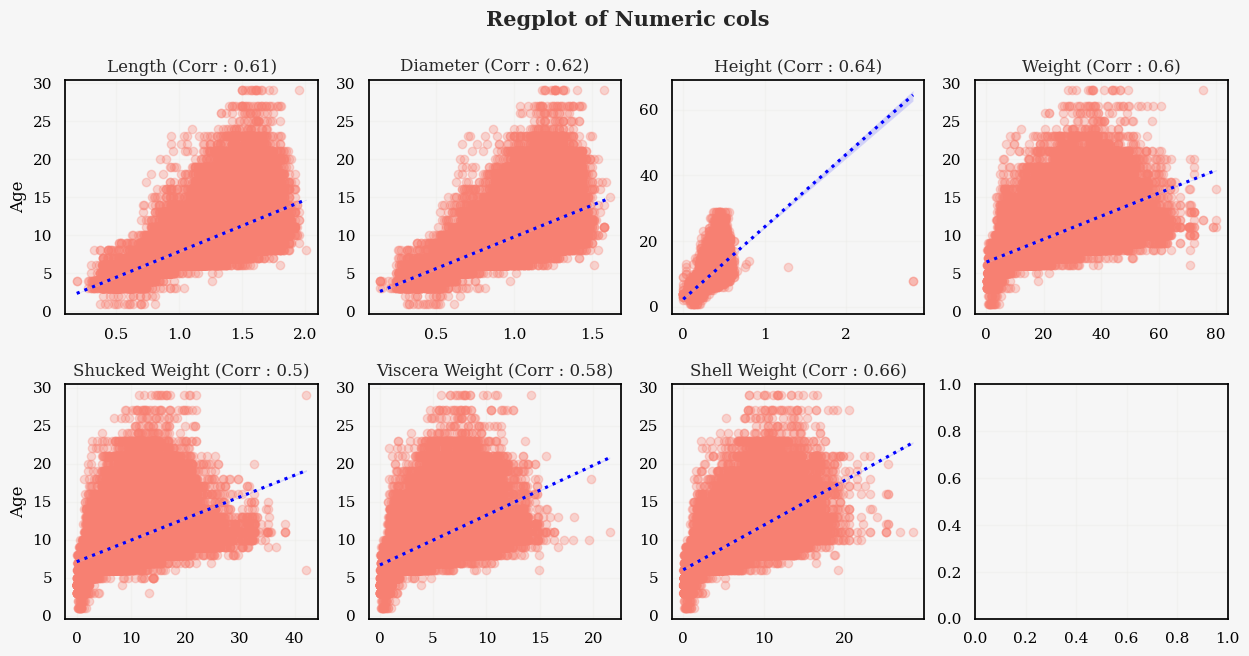

In [9]:
feature_num_cols = num_cols[:-1]

fig,ax = plt.subplots(ncols = 4, nrows = 2, figsize = (15,7))
ax = ax.flatten()

fig.subplots_adjust(hspace = 0.3)

for i,col in enumerate(feature_num_cols):
    
    corr = round(df[['Age',col]].corr().iloc[0,1],2)
    
    sns.regplot(data = df,
                x = col,
                y = 'Age',
                scatter_kws = {'alpha': 0.3,
                                'color' : 'salmon'},
                line_kws = {'color': 'blue',
                            'linestyle' : ':'},
                ax = ax[i])
    
    ax[i].set_title(f'{col} (Corr : {corr})')
    ax[i].set_xlabel('')
    
    if i % 4 != 0:
        ax[i].set_ylabel('')
        
    fig.suptitle('Regplot of Numeric cols', fontsize = 15, weight = 'bold')

>  **In fact, the variables are variables related to the crab's diameter, height, and weight**

> **Based on the findings, it can be inferred that as the crabs age, their size and weight tend to increase, indicating a growth pattern.** 🦀

Text(0.5, 0.98, 'Boxplot of Sex & Feature')

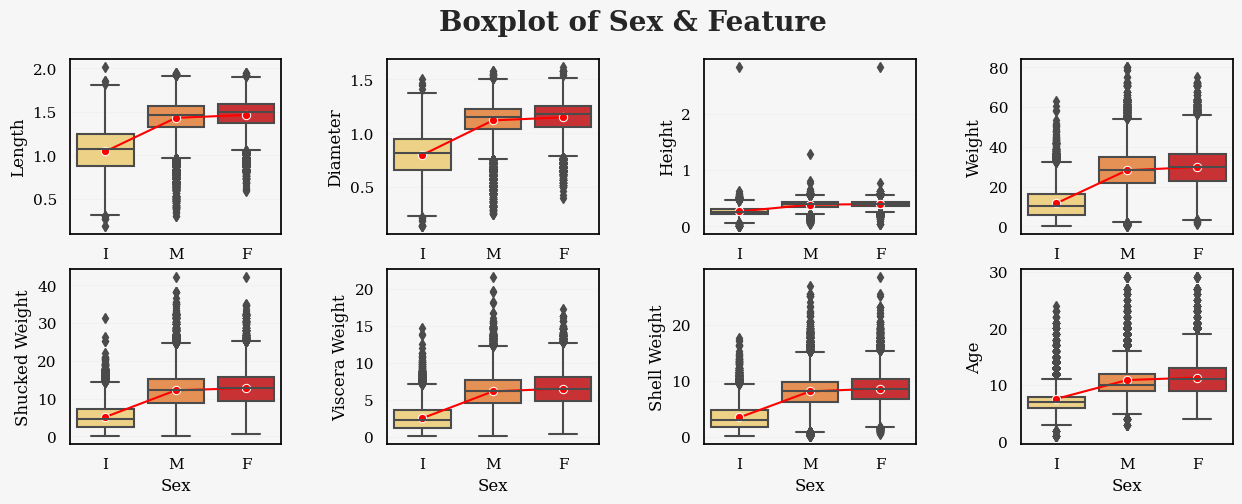

In [10]:
fig,ax = plt.subplots(nrows = 2, ncols = 4, figsize = (15,5))
ax = ax.flatten()

fig.subplots_adjust(wspace = 0.5)

for i,col in enumerate(num_cols):
    
    sns.boxplot(data = df,
                x = 'Sex',
                y = col,
                palette = 'YlOrRd',
                ax = ax[i])
    
    sns.lineplot(data = df,
                x = 'Sex',
                y = col,
                ci = None,
                marker = 'o',
                color = 'red',
                ax = ax[i])
        
        
fig.suptitle('Boxplot of Sex & Feature', fontsize = 20, weight = 'bold')

> **Crabs with undefined sex are presumed to be underdeveloped crabs. This assumption is based on the understanding that the absence of a defined sex indicates that the crab is in an immature or underdeveloped state**

Text(0.5, 1.0, 'Boxplot of Age & Feature')

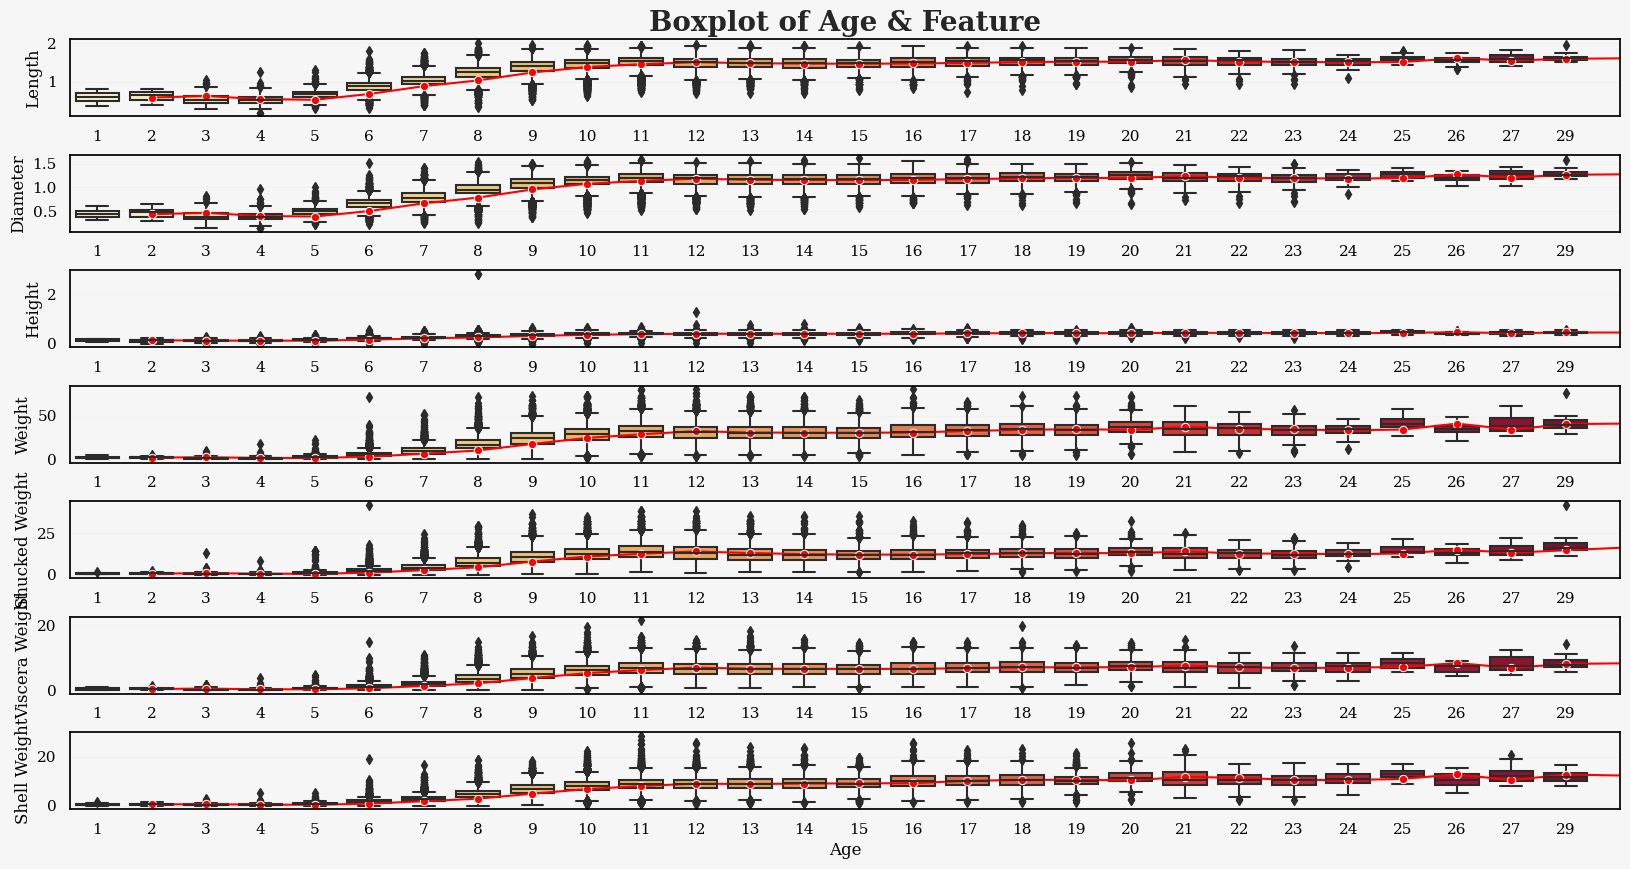

In [11]:
fig,ax = plt.subplots(nrows = 7, figsize = (20,10))

fig.subplots_adjust(hspace = 0.5)

for i,col in enumerate(feature_num_cols):
    
    sns.boxplot(data = df,
                x = 'Age',
                y = col,
                palette = 'YlOrRd',
                ax = ax[i])
    
    sns.lineplot(data = df,
                x = 'Age',
                y = col,
                ci = None,
                marker = 'o',
                color = 'red',
                ax = ax[i])
    
    ax[i].set_xlim([-0.5,28])
    
    if i != 6:
        ax[i].set_xlabel('')
        
ax[0].set_title('Boxplot of Age & Feature', fontsize = 20, weight = 'bold')

> **Crabs exhibit rapid growth between the ages of 6 months and 12 months. During this period, there is a noticeable increase in the measurements related to growth, such as diameter, height, and weight.** 

> **However, after reaching 12 months of age, the rate of growth starts to decline. The width of growth, as indicated by these measurements, decreases after the 12-month mark. This observation suggests that the growth rate of crabs slows down or stabilizes as they reach a certain level of maturity.**

# Modeling

In [12]:
X = pd.get_dummies(df.drop('Age',axis = 1))
y = df['Age']

x_train,x_test,y_train,y_test = train_test_split(X,y, random_state = 42)

In [13]:
%%time

param_grid = {
    'learning_rate': [0.1, 0.01],
    'n_estimators': [100, 200],
    'max_depth': [3, 5],
    'num_leaves': [31, 63],
    'min_child_samples': [20, 50],
    'subsample': [0.8, 0.9],
    'colsample_bytree': [0.8, 0.9]
}

cv = KFold(n_splits = 3,random_state = 42, shuffle = True)

grid_lgbm = GridSearchCV(estimator = LGBMRegressor(verbose = -1),
                            param_grid = param_grid, cv = cv, scoring = 'neg_mean_absolute_error')
grid_lgbm.fit(x_train,y_train)

print(f'{red}Best Parameter : {blu}{grid_lgbm.best_params_}{res}')
print(f'{red}Best Score : {blu}{np.abs(grid_lgbm.best_score_)}{res}')

Best Parameter : {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 5, 'min_child_samples': 50, 'n_estimators': 200, 'num_leaves': 31, 'subsample': 0.8}
Best Score : 1.403829314278835
CPU times: user 8min 19s, sys: 2min 9s, total: 10min 29s
Wall time: 5min 43s


> **Target variable was an integer variable.**

> **So, does changing the predicted value that comes out as a real number into an integer type help improve performance? let's try**

In [14]:
model = grid_lgbm.best_estimator_

cv = KFold(n_splits = 5,random_state = 42, shuffle = True)

for i,(train_idx,test_idx) in enumerate(cv.split(x_train,y_train)):

    train_x,train_y = x_train.iloc[train_idx], y_train.iloc[train_idx]
    valid_x,valid_y = x_train.iloc[test_idx], y_train.iloc[test_idx]
    
    model.fit(train_x,train_y)
    
    pred = model.predict(valid_x)
    int_pred = [round(p) for p in pred]
    
    raw_score = round(mean_absolute_error(valid_y,pred),2)
    int_score = round(mean_absolute_error(valid_y,int_pred),2)
    
    print('--' * 20)
    print(f'{i} FOLD MAE')
    print(f'{blu}RAW MAE : {raw_score}')
    print(f'{red}INT PRED MAE : {int_score}{res}')

----------------------------------------
0 FOLD MAE
RAW MAE : 1.42
INT PRED MAE : 1.39
----------------------------------------
1 FOLD MAE
RAW MAE : 1.4
INT PRED MAE : 1.37
----------------------------------------
2 FOLD MAE
RAW MAE : 1.37
INT PRED MAE : 1.35
----------------------------------------
3 FOLD MAE
RAW MAE : 1.41
INT PRED MAE : 1.38
----------------------------------------
4 FOLD MAE
RAW MAE : 1.41
INT PRED MAE : 1.38


> **It seems to work! 🦀🦀🦀🦀🦀🦀🦀🦀🦀🦀🦀🦀🦀🦀🦀🦀** 

### OOF

In [15]:
split = 5

cv = KFold(n_splits = split,random_state = 42, shuffle = True)

oof_preds = [np.zeros(len(y_test)) for _ in range(split)]

for i,(train_idx,test_idx) in enumerate(cv.split(x_train,y_train)):

    train_x,train_y = x_train.iloc[train_idx], y_train.iloc[train_idx]
    
    model.fit(train_x,train_y)
    
    pred = model.predict(x_test)
    
    oof_preds[i] += pred / split
    
    
oof_preds = np.sum(oof_preds, axis = 0)

result = [round(p) for p in oof_preds]

row_score = round(mean_absolute_error(y_test,oof_preds),2)
int_score = round(mean_absolute_error(y_test,result),2)

print(f'{blu}OOF ROW MAE : {row_score}')
print(f'{red}OOF INT MAE : {int_score}')

OOF ROW MAE : 1.4
OOF INT MAE : 1.38


> **It also seems to work! 🦀🦀🦀🦀🦀🦀🦀🦀🦀🦀🦀🦀🦀🦀🦀🦀** 

# Submission

In [16]:
test = pd.get_dummies(test)

In [17]:
split = 5

cv = KFold(n_splits = split,random_state = 42, shuffle = True)

oof_preds = [np.zeros(len(test)) for _ in range(split)]

for i,(train_idx,test_idx) in enumerate(cv.split(X,y)):

    train_x,train_y = X.iloc[train_idx], y.iloc[train_idx]
    
    model.fit(train_x,train_y)
    
    pred = model.predict(test)
    
    oof_preds[i] += pred / split
    
    
oof_preds = np.sum(oof_preds, axis = 0)

result = [round(p) for p in oof_preds]

In [18]:
sub['Age'] = result

sub.to_csv('INT.csv',index = False)

sub

,id,Age
0,74051,8
1,74052,8
2,74053,11
3,74054,10
4,74055,7
...,...,...
49363,123414,9
49364,123415,8
49365,123416,13
49366,123417,10


# Thx :) 